<center> 
    <h1>LAB1 Vanilla GAN with MNIST dataset</h1>
</center>

<h2> Lab Overview </h2>
In this lab we will look at the technical side of GANs. We will see how to create a GAN architecture. We will create a vanilla GAN and train it on MNIST dataset. <br>
MNIST is a dataset of handwritten digits from 0 to 9 in various handwrittings. After training our model with MNIST, the final goal is to generate fake handwritten digits with GAN. 
<br>
Following is the architecture we will build in this lab
<img src="../Figures/GAN.png">
<br>
<br>
<br>Following are the key points we will cover in this lab.
<ol>
    <li>Dataset preparation and loading</li>
    <li>Importing required libraries </li>
    <li>Hyperparameters</li>
    <li>Generator and Discriminator</li>
    <li>Visualization</li>
    <li>Training</li>
</ol>
    
    

<h2>Dataset preparation and loading</h2>
We will use tensorflow.keras.datasets to import our mnist dataset with the below code. 

In [259]:
from  tensorflow.keras.datasets  import  mnist

Now, we will load the dataset into train and test variables where x_train variable holds all the training values. <br>After that we normalize our images and convert them into -1 to 1 range as shown below. <br>Later we reshape them in a 1-dimensional vector to be used in our model. 

In [260]:
(x_train, _), (_, _) = mnist.load_data()

In [261]:
x_train = x_train / 127.5 - 1

In [262]:
x_train . min (),  x_train . max ()

(-1.0, 1.0)

x_train variable value is currently 28 * 28. We will flatten it for later use.

In [240]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

<h2>Importing required libraries</h2>
<br> Now we will import the modules we require for the GAN we are implementing. 

In [263]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

<h2>Hyperparameters</h2>
We will define some of the hyperparameters for our model.

In [264]:
# Dimension for noise input to gan
NOISE_DIM = 10

# Define adam optimizer, seting up learning_rate = 0.0002, beta_1 
# value helps in fast convergence.
adam = Adam(lr=0.0002, beta_1=0.5)

<h2> Generator</h2>

In [265]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [266]:
generator.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 784)             

<h2>Discriminator</h2>

In [267]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [268]:
discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)             

Now we will define the loss function and optimizer used to train the discriminator as shown below.

In [247]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Now we will connect the Generator and Discriminator and create a single model. When we train generator we dont train the discriminator. We pass an input noise z to generator, it generates a fake image x which we send to the discriminator which outputs its prediction.

In [269]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

Define the gan model.

In [270]:
gan = Model(gan_input, output)

In [271]:
gan.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
sequential_20 (Sequential)   (None, 784)               1463312   
_________________________________________________________________
sequential_21 (Sequential)   (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


Now we will define the loss function and optimizer used to train the generator as shown below.

In [272]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

Create image batch. MNIST image batches are created in sequence.

In [273]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

<h2>Visualization</h2>
<br>
Below is a small helper function to visualize our generated images and loss functions of both networks

In [274]:
def visualize_training(epoch, d_losses, g_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #Visualize after creating sample data
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

<h2> Training </h2>
<br>
Finally, we train our GAN. 

In [275]:
BATCH_SIZE = 128
EPOCHS= 50

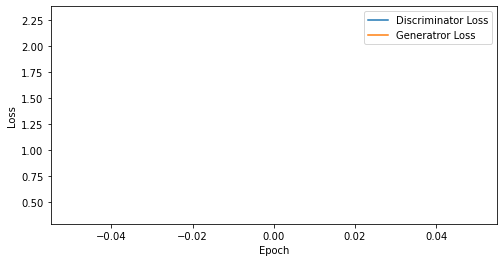

epoch: 1, Discriminator Loss: 0.39000454545021057, Generator Loss: 2.285515308380127


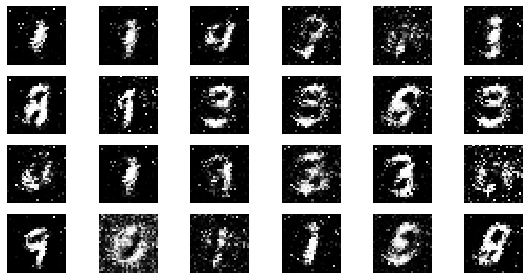

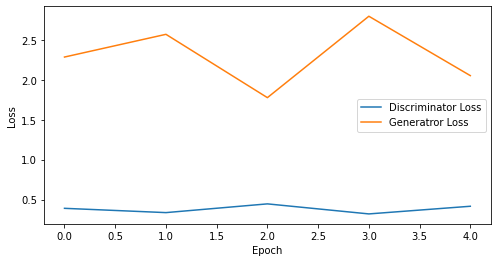

epoch: 5, Discriminator Loss: 0.38155636191368103, Generator Loss: 2.296379566192627


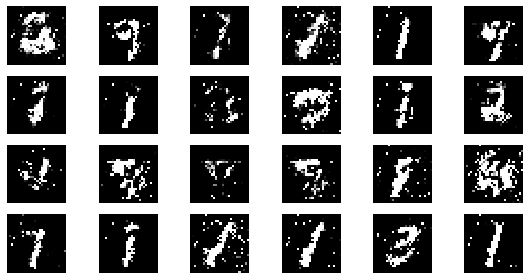

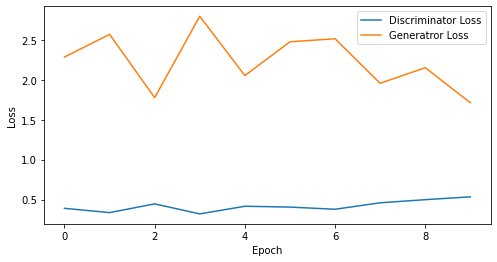

epoch: 10, Discriminator Loss: 0.4182817339897156, Generator Loss: 2.2295331954956055


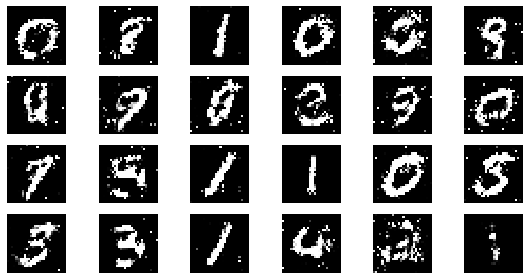

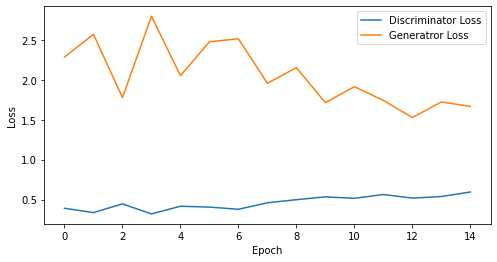

epoch: 15, Discriminator Loss: 0.46075451374053955, Generator Loss: 2.057969331741333


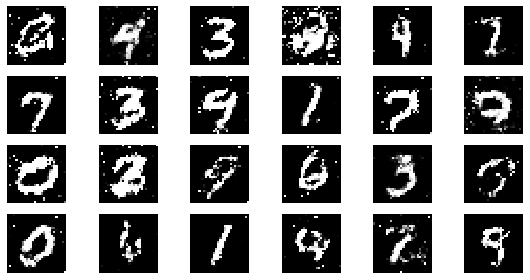

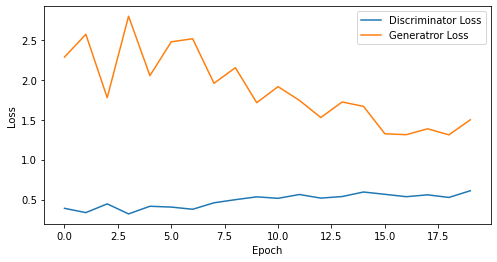

epoch: 20, Discriminator Loss: 0.4854109287261963, Generator Loss: 1.885131597518921


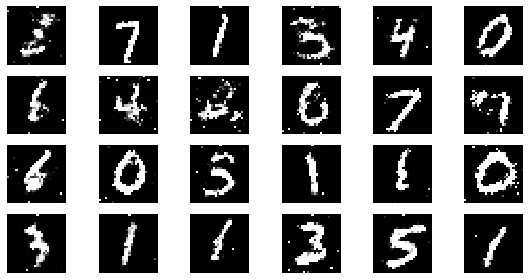

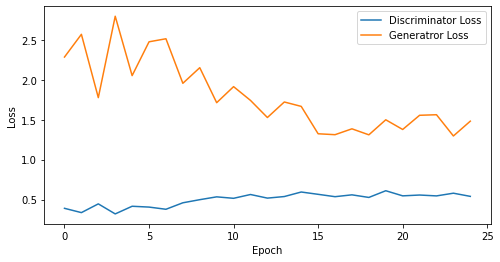

epoch: 25, Discriminator Loss: 0.4990367591381073, Generator Loss: 1.799107313156128


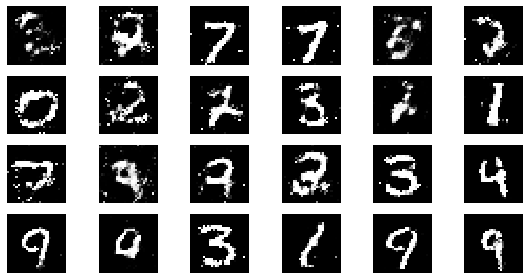

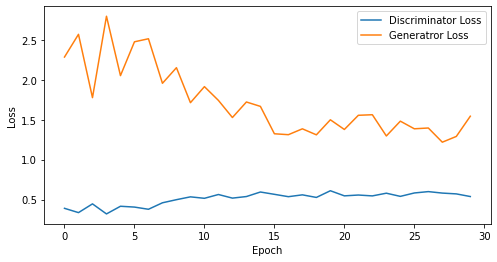

epoch: 30, Discriminator Loss: 0.5115706324577332, Generator Loss: 1.7271391153335571


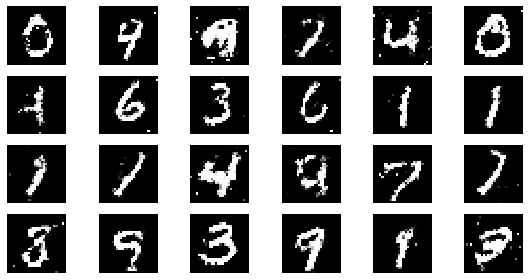

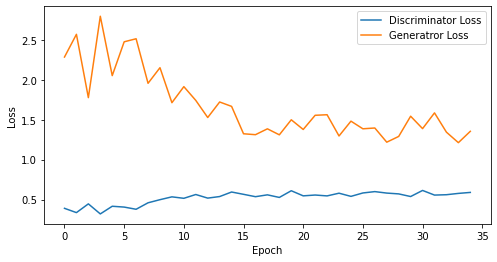

epoch: 35, Discriminator Loss: 0.5212456583976746, Generator Loss: 1.6771539449691772


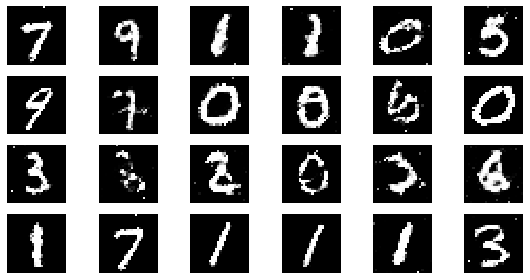

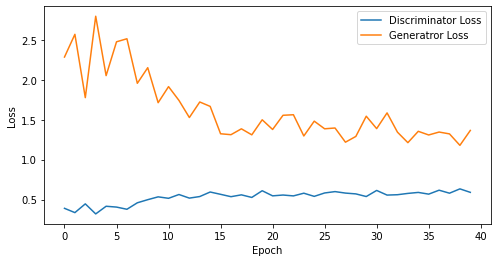

epoch: 40, Discriminator Loss: 0.5307957530021667, Generator Loss: 1.6305652856826782


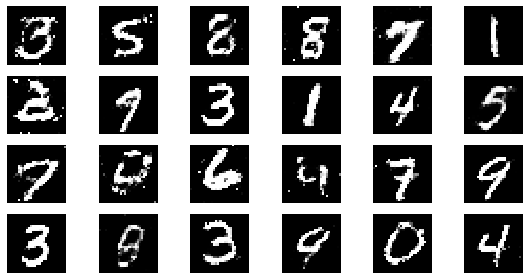

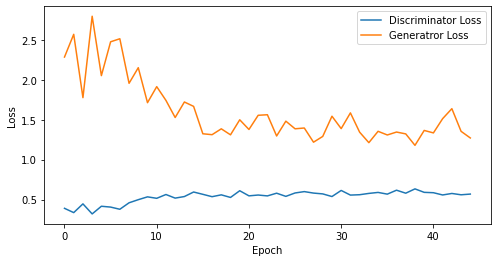

epoch: 45, Discriminator Loss: 0.5350900292396545, Generator Loss: 1.6074575185775757


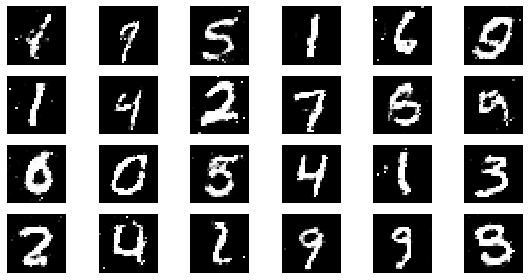

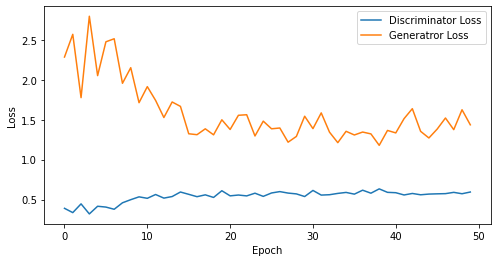

epoch: 50, Discriminator Loss: 0.5396324992179871, Generator Loss: 1.593543291091919


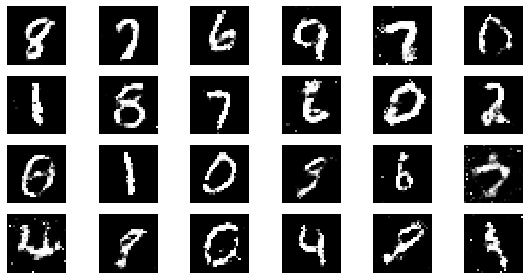

In [258]:
# This is a list for measuring loss of discriminator and gan model.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # train for each batch
    for real_images in get_batches(x_train, BATCH_SIZE):
        # Generate random noise
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # Generate fake image data
        generated_images = generator.predict(input_noise)
        
        # Define X data to learn on Gan
        x_dis = np.concatenate([real_images, generated_images])
        
        # Define Y data to be trained
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator training
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan training
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Train Generator
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)